In [1]:
import random
import time
from copy import copy

import cv2
import numpy as np
from ipycanvas import Canvas, hold_canvas
from IPython.display import clear_output, display
from PIL import Image
from tqdm.notebook import trange

In [13]:
filename='Elk.jpg'
canvas_background_color="#18041f"

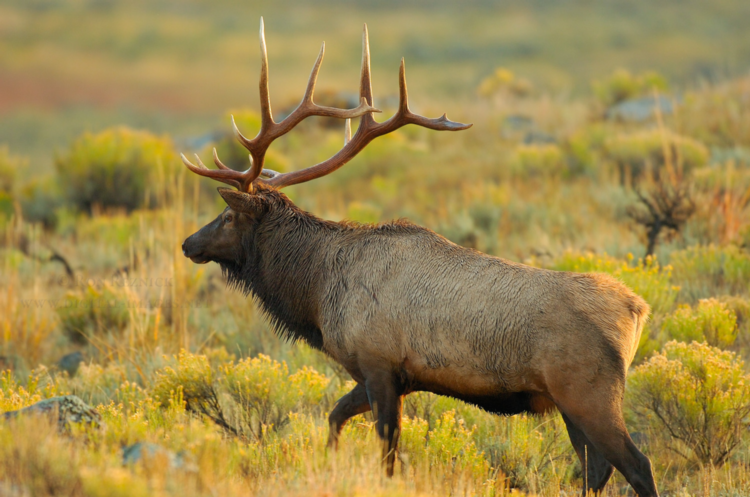

In [14]:
image = cv2.imread(filename)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.pyrDown(image)
display(Image.fromarray(image))

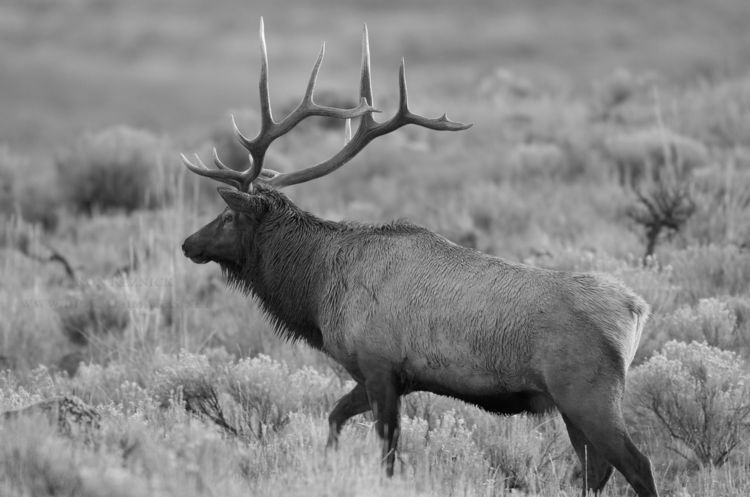

In [15]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
display(Image.fromarray(gray))

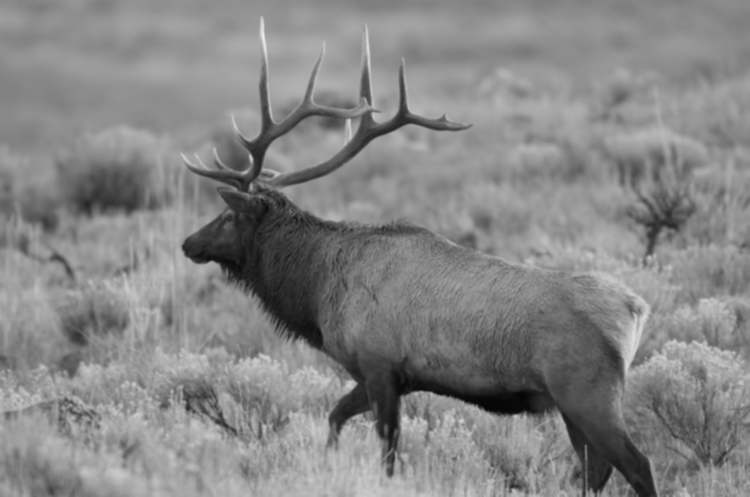

In [16]:
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
display(Image.fromarray(blurred))

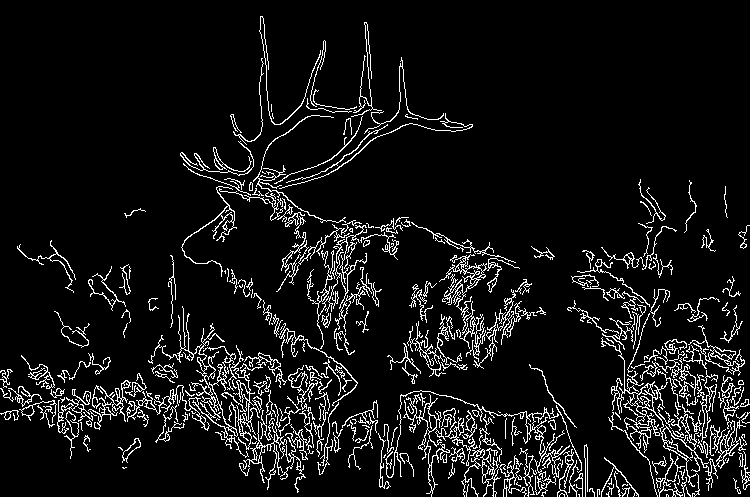

In [17]:
mid = cv2.Canny(blurred, 30, 150)
display(Image.fromarray(mid))

In [20]:
world_width = image.shape[1]-1
world_height = image.shape[0]-1
canvas = Canvas(width=world_width, height=world_height)
canvas.fill_style = canvas_background_color
canvas.fill_rect(0, 0, world_width, world_height)
display(canvas)

Canvas(height=496, width=749)

In [21]:
def analyze(c,u,d,l,r,m):
    scores={
       'up': u+random.randint(0,5),
        'down':d+random.randint(0,5),
        'left':l+random.randint(0,5),
        'right':r+random.randint(0,5)
    }
    top =  max(scores, key=lambda e: m-scores.get(e))
    if abs(scores[top] -c) < 5:
        return None
    return top

In [22]:
class Crawler:
    def __init__(self, x, y, base_color=None):
        self.x = x
        self.y = y

        self.ox = copy(x)
        self.oy = copy(y)
        self.life = 500

    def run(self, world):
        global blurred,image
        updates = {}
        
        current = blurred[self.y][self.x] 

        up = mid[self.y-1][self.x] if (self.y-1 < world_height and self.y-1 >0 and self.x < world_width and self.x > 0 ) else 0
        down = mid[self.y+1][self.x] if (self.y+1< world_height and self.y-1 >0 and self.x < world_width and self.x > 0 ) else 0
        left = mid[self.y][self.x+1] if (self.y < world_height and self.y >0 and self.x+1 < world_width and self.x+1 > 0 ) else 0
        right = mid[self.y][self.x-1] if (self.y < world_height and self.y >0 and self.x-1 < world_width and self.x-1 > 0 ) else 0
        meta = [up,down,left,right]
        meta = sum(meta)/len(meta)
        mode = analyze(current,up,down,left,right,meta)

        if mode == 'up':
            self.x += 0
            self.y += -1
            
        elif mode  == 'left':
            self.x += 1
            self.y += 0
            
        elif mode == 'right':
            self.x += -1
            self.y += 0
            
        elif mode == 'down':
            self.x += 0
            self.y += 1
        
        #respawn
        if self.life >0:
            self.life -= 1
        else:
            self.life = 500
            self.x = random.randint(0,world_width)
            self.y = random.randint(0,world_height)

        if self.y < 0:
            self.y = world_height

        if self.y > world_height:
            self.y = 0

        if self.x < 0:
            self.x = world_width

        if self.x > world_width:
            self.x = 0

        if self.x <= 0:
            self.x = world_width
        if current > 10:
            r,g,b = image[self.y][self.x]
            updates[(self.x, self.y)] = f"rgb({r},{g},{b})"
        valid = False
        return updates

In [23]:
class World:
    data = {}
    actors = []
    data_since_last_update = {}

    def __init__(self, width, height):
        self.width = width
        self.height = height

    def update(self, update_data):
        self.data.update(update_data)
        self.data_since_last_update.update(update_data)

    def updateCanvas(self, canvas):
        for loc in self.data_since_last_update:
            x, y = loc
            canvas.fill_style = self.data_since_last_update[loc]
            canvas.fill_rect(x, y, 1, 1)
        self.data_since_last_update = {}

In [24]:
def update(world):
    for ap in world.actors:
        world.update(ap.run(world))
    world.updateCanvas(canvas)

In [25]:
ppi = 50
world = World(world_width, world_height)
for y in range(1,ppi):
    for x in range(1,ppi):
        world.actors.append(
            Crawler(
                int((world_width /ppi) *x),
                int((world_height / ppi)*y)
            )
)

In [27]:
for _ in trange(600):
    with hold_canvas(canvas):
        update(world)

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
canvas.sync_image_data = True

In [ ]:
time.sleep(5)
canvas.to_file(f"{filename}.output.png")
canvas.sync_image_data = False